In [1]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!unzip "/content/Roads.v4i.coco-segmentation.zip"

Archive:  /content/Roads.v4i.coco-segmentation.zip
   creating: Roads.v4i.coco-segmentation/annotations/
  inflating: Roads.v4i.coco-segmentation/annotations/_annotations.coco.json  
  inflating: Roads.v4i.coco-segmentation/README.dataset.txt  
  inflating: Roads.v4i.coco-segmentation/README.roboflow.txt  
   creating: Roads.v4i.coco-segmentation/test/
  inflating: Roads.v4i.coco-segmentation/test/11_jpg.rf.4aafd416d2da16bc5898511fd0f6bae6.jpg  
   creating: Roads.v4i.coco-segmentation/train/
  inflating: Roads.v4i.coco-segmentation/train/1_jpg.rf.7f9935c1863bcd1e0d8f31cb28811df0.jpg  
  inflating: Roads.v4i.coco-segmentation/train/10_jpg.rf.cbefeae1444599761d4a87c6a8c2bdda.jpg  
  inflating: Roads.v4i.coco-segmentation/train/12_jpg.rf.77d7ca9c2128869476b796487afbe58e.jpg  
  inflating: Roads.v4i.coco-segmentation/train/13_jpg.rf.13a6f32d6b8e3eb19768ac4b9f605081.jpg  
  inflating: Roads.v4i.coco-segmentation/train/2_jpg.rf.baedcffd8e5780f50192519985adb294.jpg  
  inflating: Roads.v4i.c

In [3]:
#importing the libraries
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os
batchSize=2
imageSize=[800,800]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
trainDir="/content/Roads.v4i.coco-segmentation/train"

imgs=[]
for pth in os.listdir(trainDir):
    imgs.append(trainDir+"/"+pth)

In [5]:
from pycocotools.coco import COCO
# Initialize the COCO api for instance annotations
coco=COCO("/content/Roads.v4i.coco-segmentation/annotations/_annotations.coco.json")

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[{'id': 0, 'name': 'Roads', 'supercategory': 'none'}, {'id': 1, 'name': 'Roads', 'supercategory': 'Roads'}]


In [13]:
img = cv2.imread("/content/Roads.v4i.coco-segmentation/train/10_jpg.rf.cbefeae1444599761d4a87c6a8c2bdda.jpg") 
img.shape 

(800, 800, 3)

In [20]:
imageSize=[800,800]
def loadData():
  batch_Imgs=[]
  batch_Data=[]
  for i in range(batchSize):
        indices= [0,1,2,3,4,5,6,8,9]
        idx = random.choice(indices)
        img_info = coco.loadImgs([idx])[0]
        img = cv2.imread("/content/Roads.v4i.coco-segmentation/train/"+img_info["file_name"])  
        img = cv2.resize(img, imageSize, cv2.INTER_LINEAR) 
        annIds = coco.getAnnIds(imgIds=img_info['id'], catIds=[1], iscrowd=None) 
        anns = coco.loadAnns(annIds)
        num_objs = len(anns)
        masks=[]
        mask = np.zeros((img.shape[0],img.shape[1]))
        for i in range(len(anns)):
            mask = np.maximum(coco.annToMask(anns[i]), mask)
        masks.append(mask)
        if num_objs==0: return loadData()
        boxes = torch.zeros([num_objs,4], dtype=torch.float32)
        for i in range(num_objs):
            [x,y,w,h]=anns[i]["bbox"]
            boxes[i] = torch.tensor([x,y,x+w,y+h])
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        img = torch.as_tensor(img, dtype=torch.float32)
        data = {}
        data["boxes"] =  boxes
        data["labels"] =  torch.ones((num_objs,), dtype=torch.int64)   
        data["masks"] = masks
        batch_Imgs.append(img)
        batch_Data.append(data)  
  
  batch_Imgs=torch.stack([torch.as_tensor(d) for d in batch_Imgs],0)
  batch_Imgs = batch_Imgs.swapaxes(1, 3).swapaxes(2, 3)
  return batch_Imgs, batch_Data

In [7]:
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [8]:
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)

In [9]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [10]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)

In [11]:
model.train()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [21]:
for i in range(1001):
   images, targets = loadData()
   images = list(image.to(device) for image in images)
   targets=[{k: v.to(device) for k,v in t.items()} for t in targets]
   
   optimizer.zero_grad()
   loss_dict = model(images, targets)
   losses = sum(loss for loss in loss_dict.values())
   
   losses.backward()
   optimizer.step()
   
   print(i,'loss:', losses.item())
   if i%200==0:
           torch.save(model.state_dict(), str(i)+".torch")
           print("Save model to:",str(i)+".torch")

0 loss: 91.16395568847656
Save model to: 0.torch
1 loss: 46.92461013793945
2 loss: 92.34689331054688
3 loss: 21.99730682373047
4 loss: 15.169342994689941
5 loss: 19.036088943481445
6 loss: 77.62957000732422
7 loss: 77.18114471435547
8 loss: 14.64589786529541
9 loss: 7.993628025054932
10 loss: 27.059785842895508
11 loss: 27.78675651550293
12 loss: 5.792140007019043
13 loss: 7.13115119934082
14 loss: 20.330753326416016
15 loss: 5.570339202880859
16 loss: 24.951858520507812
17 loss: 11.587393760681152
18 loss: 5.458474159240723
19 loss: 6.03233003616333
20 loss: 5.996604919433594
21 loss: 14.404796600341797
22 loss: 10.977535247802734
23 loss: 7.333967685699463
24 loss: 12.911032676696777
25 loss: 8.233549118041992
26 loss: 4.605226039886475
27 loss: 2.0407862663269043
28 loss: 7.3477864265441895
29 loss: 5.763381004333496
30 loss: 4.158860206604004
31 loss: 4.404574871063232
32 loss: 6.609726905822754
33 loss: 3.7353084087371826
34 loss: 3.5209646224975586
35 loss: 2.4969921112060547
36 

In [22]:
#inference 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)
model.load_state_dict(torch.load("/content/1000.torch"))
model.to(device)# move model to the right devic
model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [23]:
images = cv2.imread("/content/Roads.v4i.coco-segmentation/test/11_jpg.rf.4aafd416d2da16bc5898511fd0f6bae6.jpg")
images = cv2.resize(images, imageSize, cv2.INTER_LINEAR)
images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
images=images.swapaxes(1, 3).swapaxes(2, 3)
images = list(image.to(device) for image in images)

In [24]:
with torch.no_grad():
    pred = model(images)

In [25]:
pred

[{'boxes': tensor([[  0.0000, 451.2770, 800.0000, 784.7550],
          [147.2438, 526.2065, 759.9379, 726.2720],
          [181.4774, 459.9043, 620.3747, 689.3658],
          [116.8784, 603.8898, 666.1941, 712.7722]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9821, 0.4882, 0.1538, 0.0739], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
           

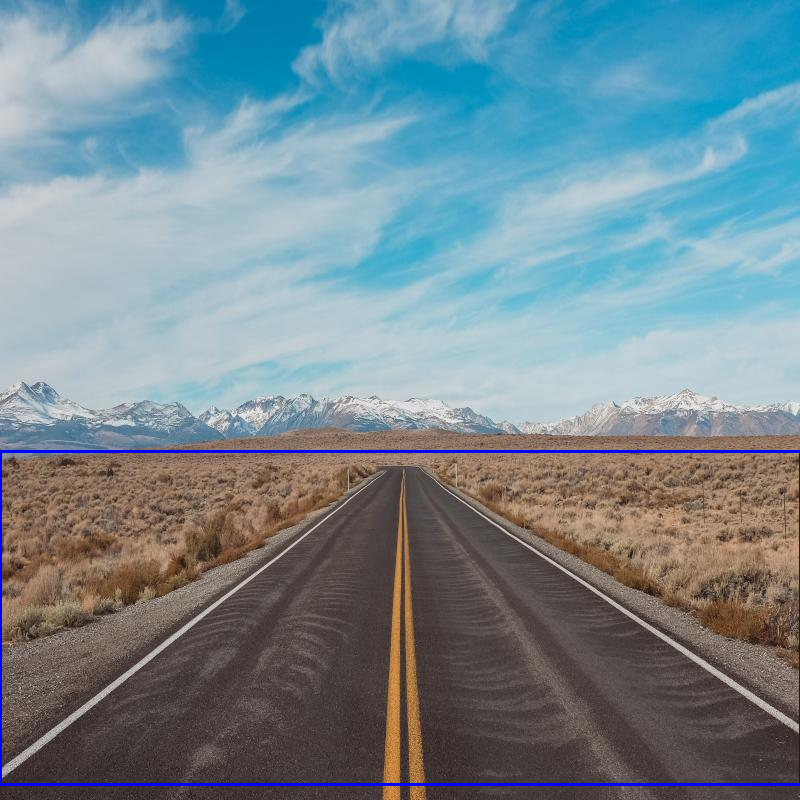

In [26]:
import cv2
from google.colab.patches import cv2_imshow
images = cv2.imread("/content/Roads.v4i.coco-segmentation/test/11_jpg.rf.4aafd416d2da16bc5898511fd0f6bae6.jpg")
images=cv2.rectangle(images, (0,451), (800,784), (255,0,0), 2)
cv2_imshow(images)

In [30]:
pred[0]['masks'][0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

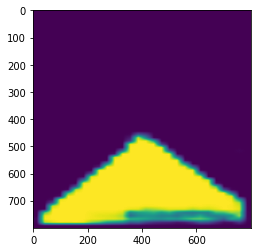

In [35]:
import matplotlib.pyplot as plt
plt.imshow(pred[0]['masks'][0].cpu().permute(1,2,0).squeeze().detach().numpy())